In [44]:
import numpy as np
import os
import matplotlib.pyplot as plt
import dimod
from dimod.generators.constraints import combinations
from hybrid.reference import KerberosSampler

In [15]:
tiles = np.load('data/knots_tiles.npy')

In [16]:
tiles.shape

(9, 10, 10, 3)

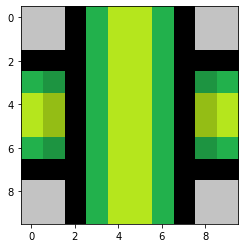

In [17]:
plt.imshow(tiles[5])
plt.show()

In [18]:
maps = np.load('data/knots_maps.npy')

In [19]:
maps.shape

(5, 10, 10)

In [22]:
def display_image_from_tilemap(tilemap, tiles, x_dim = maps[0].shape[0], y_dim = maps[0].shape[1], tile_size=tiles[0].shape[0]):
    output_img = np.zeros((x_dim*tile_size,y_dim*tile_size,3))
    for i in range(x_dim):
        for j in range(y_dim):
            output_img[i*tile_size:i*tile_size+tile_size, j*tile_size:j*tile_size+tile_size, :] = tiles[int(tilemap[i,j])]
    fig = plt.figure(figsize = (8,8))
    ax3 = fig.add_subplot(111)
    ax3.imshow(np.uint8(output_img), interpolation='none')
    plt.show()

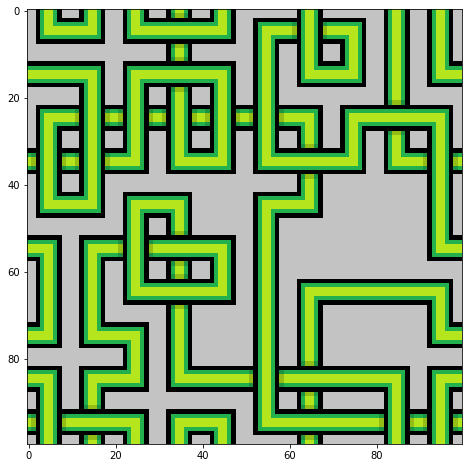

In [23]:
display_image_from_tilemap(maps[3], tiles)

In [24]:
top_allowed = set()

In [25]:
for map in maps:
    for i in range(1, len(map)):
        for j in range(len(map[i])):
            top_allowed.add((map[i][j], map[i-1][j]))

In [26]:
left_allowed = set()

In [27]:
for map in maps:
    for i in range(len(map)):
        for j in range(1, len(map[i])):
            left_allowed.add((map[i][j], map[i][j-1]))

In [28]:
all_combinations = set()

In [29]:
for i in range(len(tiles)):
    for j in range(len(tiles)):
        all_combinations.add((i,j))

In [30]:
left_not_allowed = all_combinations - left_allowed

In [31]:
top_not_allowed = all_combinations - top_allowed

In [42]:
def get_label(row, col, tile):
    return "{row},{col}_{tile}".format(**locals())

In [35]:
numTiles = tiles.shape[0]
numRows = tiles.shape[1]
numColumns = tiles.shape[2]

In [40]:
bqm = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.SPIN)

In [45]:
for i in range(1,numRows):
    for j in range(numColumns):
        for k in top_not_allowed:
            comb = [get_label(i,j,k[0]), get_label(i-1,j,k[1])]
            comb_bqm = combinations(comb, 1)
            bqm.update(comb_bqm)

In [46]:
for i in range(numRows):
    for j in range(1,numColumns):
        for k in left_not_allowed:
            comb = [get_label(i,j,k[0]), get_label(i,j-1,k[1])]
            comb_bqm = combinations(comb, 1)
            bqm.update(comb_bqm)

In [47]:
for i in range(numRows):
    for j in range(numColumns):
        comb = [get_label(i,j,k) for k in range(numTiles)]
        comb_bqm = combinations(comb, 1,strength=20)
        bqm.update(comb_bqm)

In [48]:
countPerTile = round((numColumns*numRows)/numTiles)
for k in range(numTiles):
    comb = []
    for i in range(numRows):
        for j in range(numColumns):
            comb.append(get_label(i,j,k))
    comb_bqm = combinations(comb, countPerTile)
    bqm.update(comb_bqm)

In [ ]:
solution = KerberosSampler().sample(bqm,
                                    max_iter=10,
                                    convergence=3,
                                    qpu_params={'label': 'Map Generation'})

In [ ]:
result = solution.first.sample

In [33]:
gen_img = np.zeros(maps[0].shape)
for key in result:
    if result[key] > 0:
        coords,tile = key.split("_")
        tile = int(tile)
        x,y = coords.split(",")
        x = int(x)
        y = int(y)
        gen_img[x,y] = tile

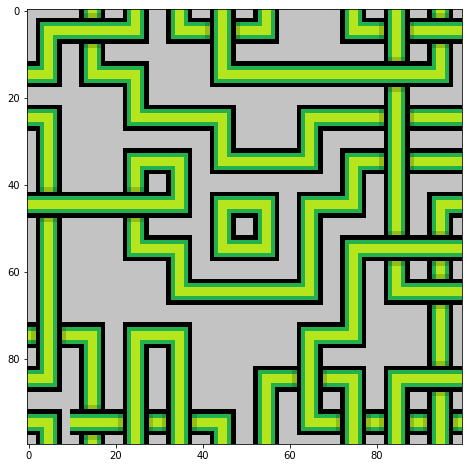

In [34]:
display_image_from_tilemap(gen_img, tiles)